# Load Libraries and Data

In [1]:
import os, math
import numpy as np
import pandas as pd
from scipy import signal

from sklearn.metrics import f1_score
from sklearn import tree, linear_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('../input/liverpool-ion-switching/train.csv')
test = pd.read_csv('../input/liverpool-ion-switching/test.csv')

# Split trainset in groups of 100k and 500k consecutive rows
train['group']  = np.arange(train.shape[0])//100_000
train['group2'] = np.arange(train.shape[0])//500_000

# Split testset in groups of 100k consecutive rows
test['group']   = np.arange(test.shape[0])//100_000

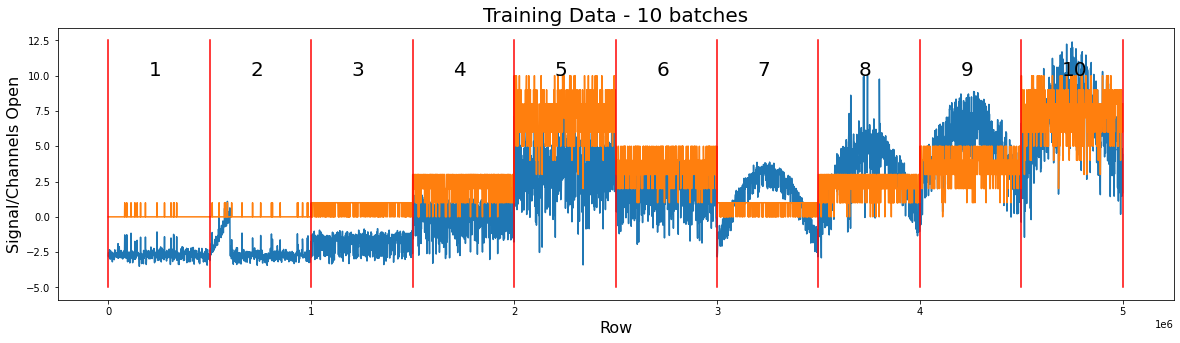

In [3]:
# look at the signal and open channels

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000, i*500000], [-5,12.5], 'r')
for j in range(10): plt.text(j*500000+200000, 10, str(j+1), size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal/Channels Open',size=16); 
plt.title('Training Data - 10 batches',size=20)
plt.show()

# Correct the bias and scale
* Train 500k groups 4 and 9 and test 100k groups 5 and 7 needs to be shifted by +2exp(1).  
* Other groups are shifted by +exp(1).  
* All groups must be rescaled by 1.25 to match open_channels scale

In [4]:
train.loc[ (train.group2==4)|(train.group2==9) ,'signal'] += np.exp(1)
test.loc[  ( test.group ==5)|( test.group ==7) ,'signal'] += np.exp(1)

train['signal'] += np.exp(1)
train['signal'] /= 1.25

test['signal'] += np.exp(1)
test['signal'] /= 1.25

# See the drift

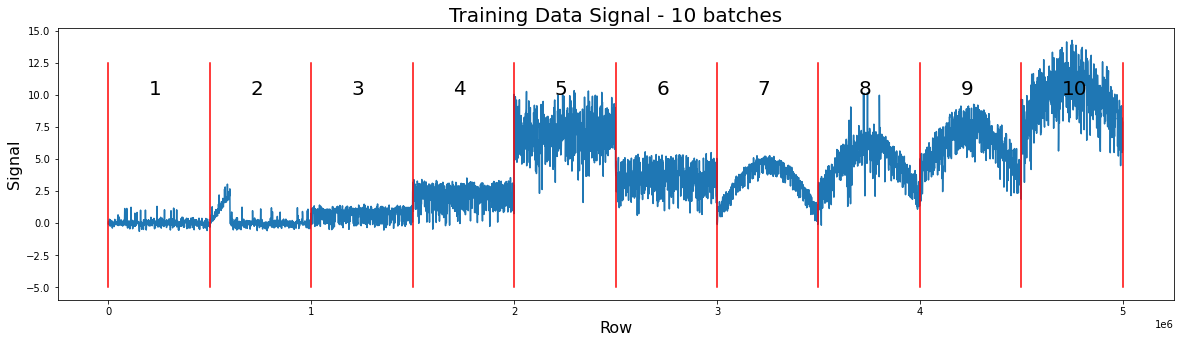

In [5]:
# raw signal

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0, train.shape[0], res), train.signal[0::res])
for i in range(11): plt.plot([i*500000, i*500000], [-5,12.5], 'r')
for j in range(10): plt.text(j*500000+200000, 10, str(j+1), size=20)
plt.xlabel('Row', size=16); plt.ylabel('Signal', size=16); 
plt.title('Training Data Signal - 10 batches', size=20)
plt.show()

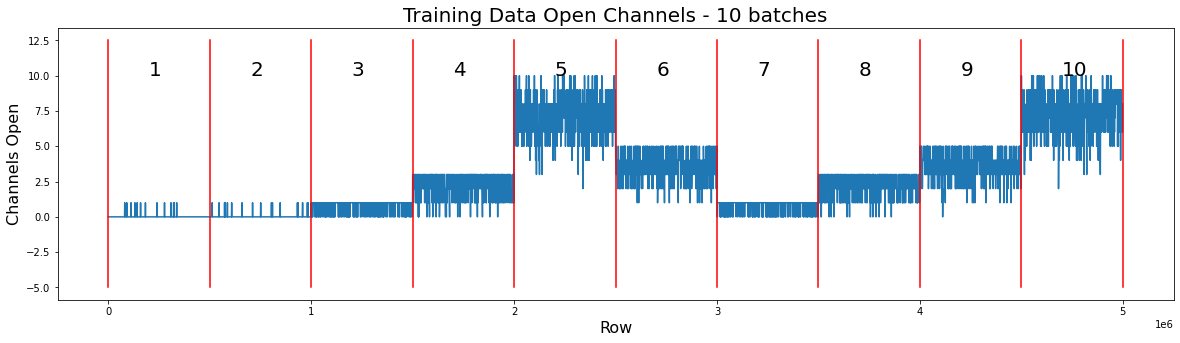

In [6]:
# corresponding open channels

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0, train.shape[0], res), train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000], [-5,12.5], 'r')
for j in range(10): plt.text(j*500000+200000, 10, str(j+1), size=20)
plt.xlabel('Row', size=16); plt.ylabel('Channels Open', size=16); 
plt.title('Training Data Open Channels - 10 batches', size=20)
plt.show()

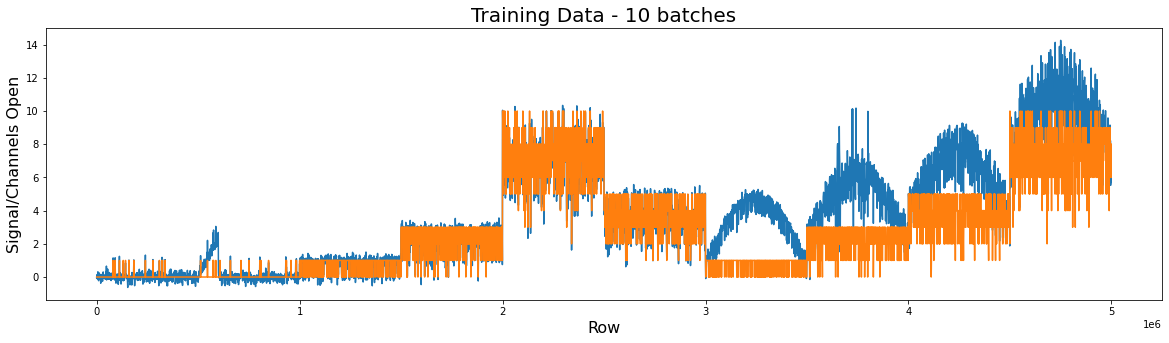

In [7]:
# stack above 2

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
plt.xlabel('Row',size=16); plt.ylabel('Signal/Channels Open',size=16); 
plt.title('Training Data - 10 batches',size=20)
plt.show()

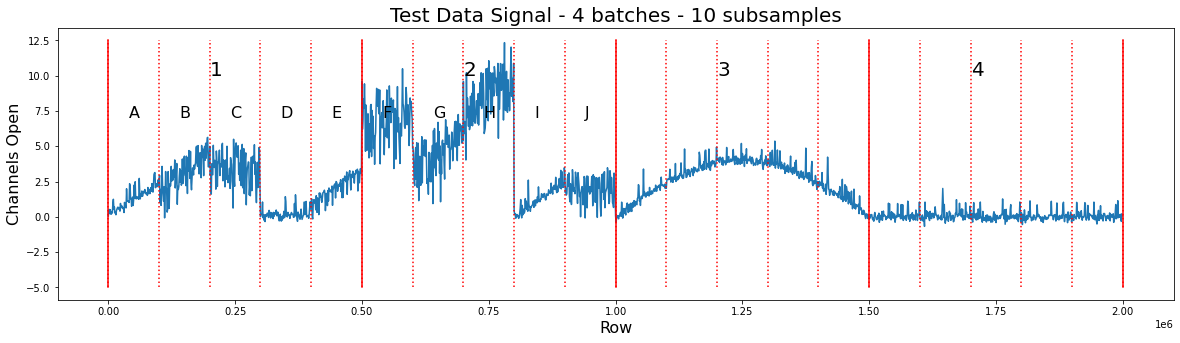

In [8]:
plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0, test.shape[0], res), test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000], [-5,12.5], 'r')
for j in range(21): plt.plot([j*100000,j*100000], [-5,12.5], 'r:')
for k in range(4): plt.text(k*500000+200000, 10, str(k+1), size=20)
for k in range(10): plt.text(k*100000+40000, 7, let[k], size=16)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open', size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples', size=20)
plt.show()

# Correct the drift
After analysis, the drift is found described with the formula:  
4 sin( 2 pi x range(500000) / 1000000 )

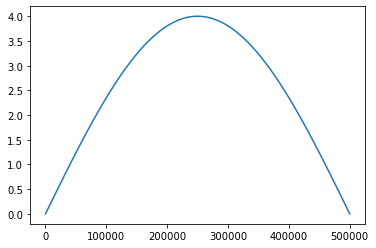

In [9]:
SINE_DRIFT = 4*np.sin(  2*np.pi*np.arange(500000)/1000000 )
plt.plot( SINE_DRIFT );

In [10]:
train.loc[ train.group2==6, 'signal' ] -= SINE_DRIFT
train.loc[ train.group2==7, 'signal' ] -= SINE_DRIFT
train.loc[ train.group2==8, 'signal' ] -= SINE_DRIFT
train.loc[ train.group2==9, 'signal' ] -= SINE_DRIFT

train.signal.iloc[ 500000:600000 ]-= SINE_DRIFT[:100000]

test.signal.iloc[ :100000 ]       -= SINE_DRIFT[:100000]
test.signal.iloc[ 100000:200000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 400000:500000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 600000:700000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 700000:800000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 800000:900000 ] -= SINE_DRIFT[:100000]

test.loc[ (test.group>=10)&(test.group<=14), 'signal' ] -= SINE_DRIFT

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


See the signal again

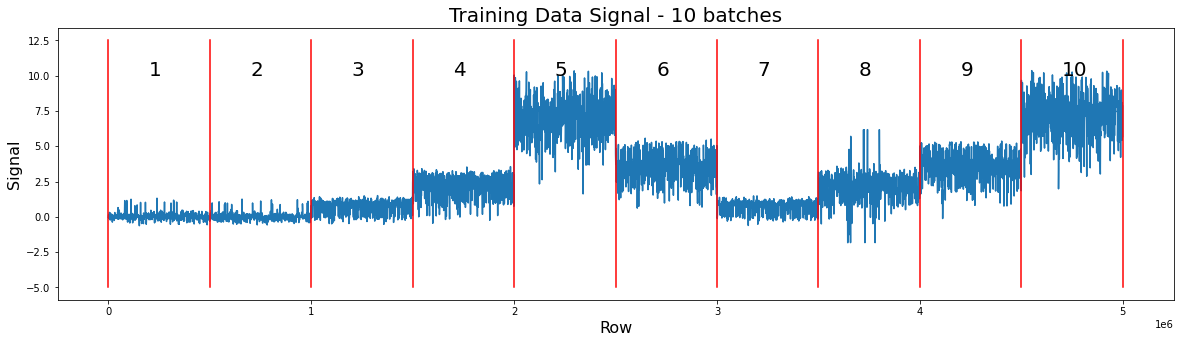

In [11]:
# train raw signal

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0, train.shape[0], res), train.signal[0::res])
for i in range(11): plt.plot([i*500000, i*500000], [-5,12.5], 'r')
for j in range(10): plt.text(j*500000+200000, 10, str(j+1), size=20)
plt.xlabel('Row', size=16); plt.ylabel('Signal', size=16); 
plt.title('Training Data Signal - 10 batches', size=20)
plt.show()

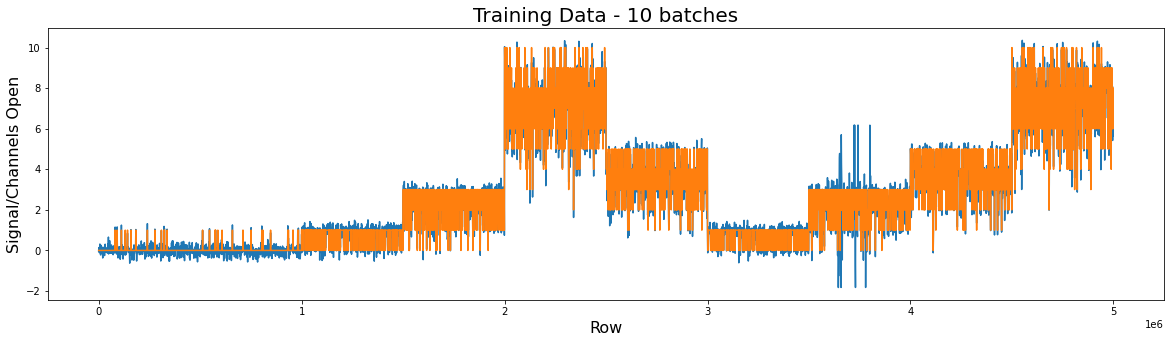

In [12]:
# train signal and open channels

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
plt.xlabel('Row',size=16); plt.ylabel('Signal/Channels Open',size=16); 
plt.title('Training Data - 10 batches',size=20)
plt.show()

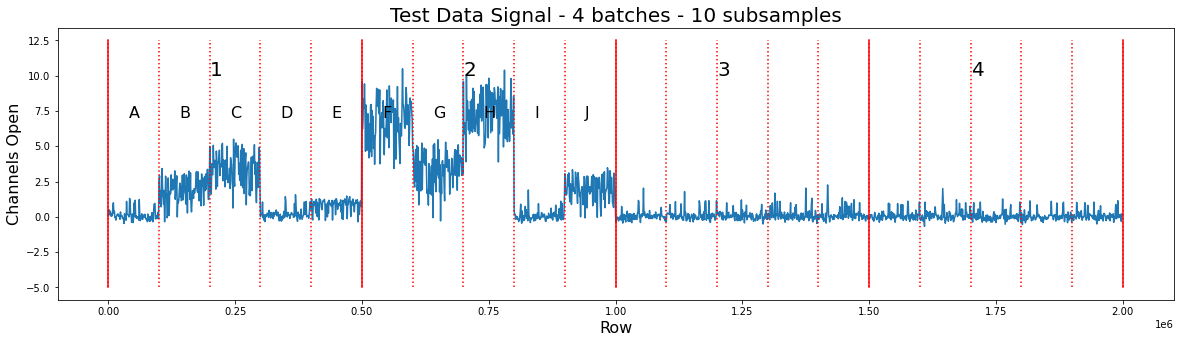

In [13]:
# test signal

plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0, test.shape[0], res), test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000], [-5,12.5], 'r')
for j in range(21): plt.plot([j*100000,j*100000], [-5,12.5], 'r:')
for k in range(4): plt.text(k*500000+200000, 10, str(k+1), size=20)
for k in range(10): plt.text(k*100000+40000, 7, let[k], size=16)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open', size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples', size=20)
plt.show()

# Remove/Decrease 50Hz power line interference

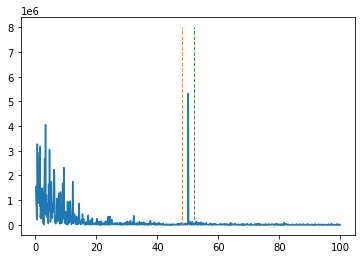

In [14]:
# Power line 50Hz interference is that small peak of the plot below
# We used Fourier Transform to remove it precisely
f = np.fft.fft( train.loc[train.group==3].signal )
f_axis = np.fft.fftfreq(len(f), 1e-4)
plt.plot(f_axis[1:1000], (np.abs(f)**2)[1:1000] )
plt.plot([48, 48], [0, 8e6], '--', lw=1)
plt.plot([52, 52], [0, 8e6], '--', lw=1);

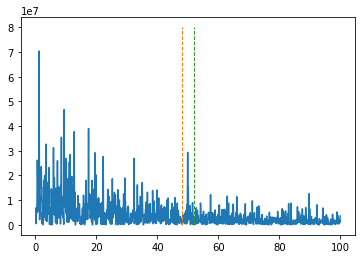

In [15]:
# Power line 50Hz interference is that small peak of the plot below
# We used Fourier Transform to remove it precisely
f = np.fft.fft( train.loc[train.group==45].signal )
f_axis = np.fft.fftfreq(len(f), 1e-4)
plt.plot(f_axis[1:1000], (np.abs(f)**2)[1:1000] )
plt.plot([48, 48], [0, 8e7], '--', lw=1)
plt.plot([52, 52], [0, 8e7], '--', lw=1);

In [16]:
# Removing 100% of power line interference can remove also usefull information that lies in the 50Hz spectrum.
# Thats why we removed only 50% of powerline interference in order to keep some useful signal present in the 50Hz.
# Remove 50Hz in batches of 100k rows.

for g in range( train.group.max()+1 ):
    f = np.fft.fft( train.loc[train.group==g].signal )
    freq = np.abs( np.fft.fftfreq(len(f), 1e-4) )
    f[ (freq >= 49.8)& (freq <= 50.2) ] = 0.5*f[ (freq >= 49.8)& (freq <= 50.2) ]
    train.loc[train.group==g,'signal'] = np.fft.ifft( f ).real
    
for g in range( test.group.max()+1 ):
    f = np.fft.fft( test.loc[test.group==g].signal )
    freq = np.abs( np.fft.fftfreq(len(f), 1e-4) )
    f[ (freq >= 49.8)& (freq <= 50.2) ] = 0.5*f[ (freq >= 49.8)& (freq <= 50.2) ]
    test.loc[test.group==g,'signal'] = np.fft.ifft( f ).real

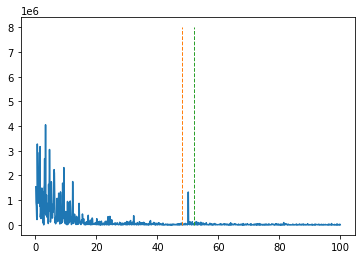

In [17]:
# Power line 50Hz interference is that small peak of the plot below
# We used Fourier Transform to remove it precisely
f = np.fft.fft( train.loc[train.group==3].signal )
f_axis = np.fft.fftfreq(len(f), 1e-4)
plt.plot(f_axis[1:1000], (np.abs(f)**2)[1:1000] )
plt.plot([48, 48], [0, 8e6], '--', lw=1)
plt.plot([52, 52], [0, 8e6], '--', lw=1);

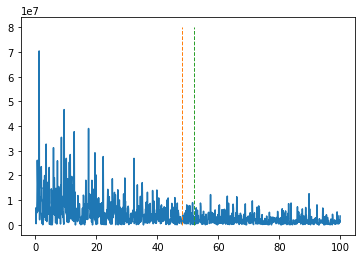

In [18]:
# Power line 50Hz interference is that small peak of the plot below
# We used Fourier Transform to remove it precisely
f = np.fft.fft( train.loc[train.group==45].signal )
f_axis = np.fft.fftfreq(len(f), 1e-4)
plt.plot(f_axis[1:1000], (np.abs(f)**2)[1:1000] )
plt.plot([48, 48], [0, 8e7], '--', lw=1)
plt.plot([52, 52], [0, 8e7], '--', lw=1);

# Replace outliers

group 4

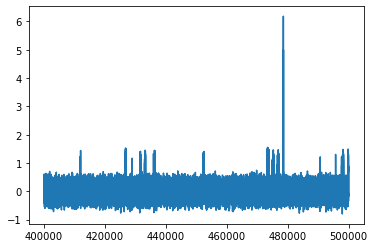

In [19]:
train.loc[train.group==4].signal.plot();

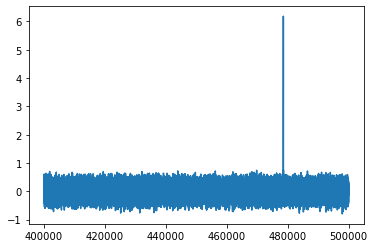

In [20]:
train['noise'] = train['signal'] - train['open_channels']
train.loc[train.group==4].noise.plot();

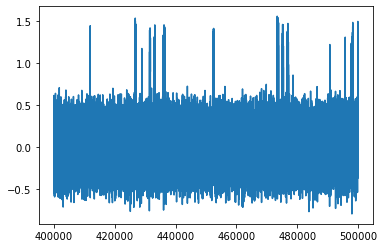

In [21]:
noise_amp = train.loc[train.group==4, 'signal' ].std()
cond = (train.group==4) & (train.noise>1.0)
num_outliers = len(train.loc[ cond, 'signal' ])
train.loc[ cond, 'signal' ] = train.loc[ cond, 'open_channels' ] + np.random.normal( 0, noise_amp, num_outliers )  # Just add gaussian noise with std 0.20

train.loc[train.group==4].signal.plot();

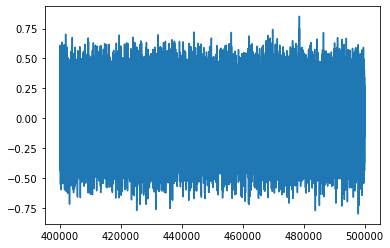

In [22]:
train['noise'] = train['signal'] - train['open_channels']
train.loc[train.group==4].noise.plot();

in group2 7

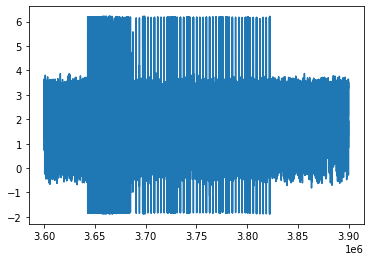

In [23]:
train.loc[train.group.isin([36, 37, 38])].signal.plot();

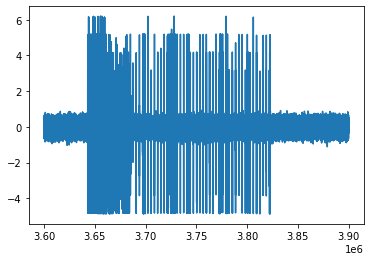

In [24]:
train['noise'] = train['signal'] - train['open_channels']
train.loc[train.group.isin([36, 37, 38])].noise.plot();

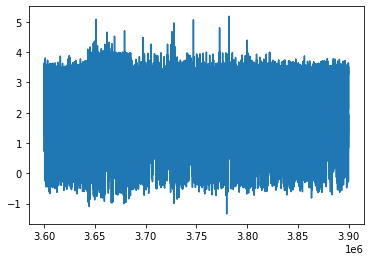

In [25]:
for _ in range(3):
    noise_amp = train.loc[train.group.isin([36, 37, 38]), 'signal'].std()
    train['noise'] = train['signal'] - train['open_channels']
    cond = (train.group.isin([36, 37, 38])) & (np.abs(train.noise)>1.0)
    num_outliers = len(train.loc[ cond, 'signal' ])
    train.loc[ cond, 'signal' ] = train.loc[ cond, 'open_channels' ] + np.random.normal( 0, noise_amp, num_outliers )

train.loc[train.group.isin([36, 37, 38])].signal.plot();

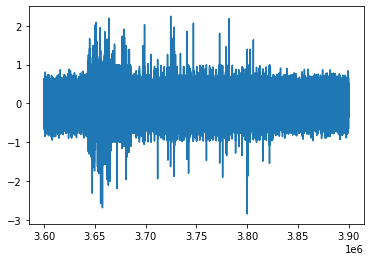

In [26]:
train['noise'] = train['signal'] - train['open_channels']
train.loc[train.group.isin([36, 37, 38])].noise.plot();

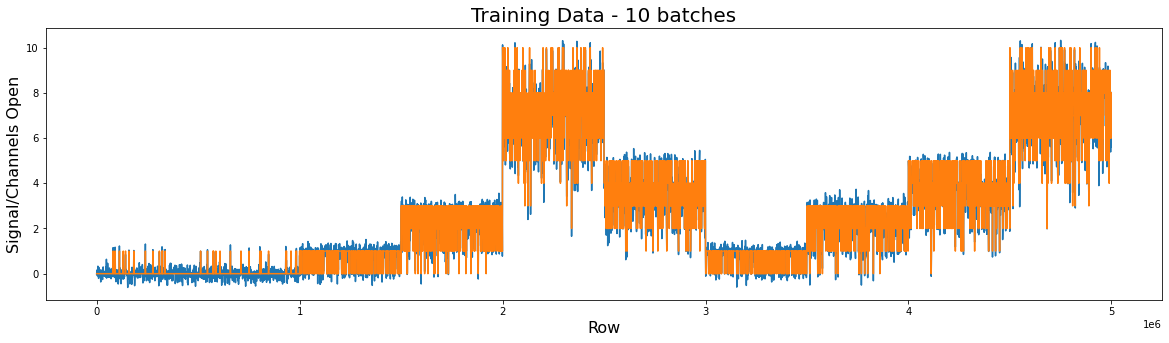

In [27]:
# train signal and open channels

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
plt.xlabel('Row',size=16); plt.ylabel('Signal/Channels Open',size=16); 
plt.title('Training Data - 10 batches',size=20)
plt.show()

# Save the cleaned data

In [28]:
train[['time','signal','open_channels']].to_csv('train_full_clean.csv', index=False )
test [['time','signal']].to_csv('test_full_clean.csv', index=False )